**Introduction**

In machine learning, binary linear classifiers can be utilized for multi-class classificiation in several ways. Two notable approaches include one-against-all and one-against-one. The goal of this homework is to implement multi-class classification using Rosenblatt's perceptrons (or like, see specifics below) using numpy and Tensorflow. 

**Dataset**

The code below generates the dataset to be used in this homework

/tmp/ipykernel_31062/2085528585.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  class3_samples = np.random.multivariate_normal(


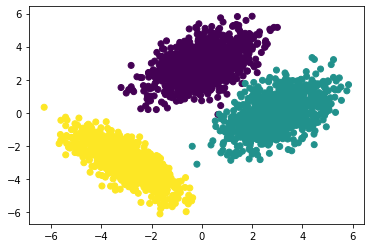

In [1]:
import numpy as np

num_samples_per_class = 1000
class1_samples = np.random.multivariate_normal(
mean=[0, 3],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class2_samples = np.random.multivariate_normal(
mean=[3, 0],
cov=[[1, 0.5],[0.5, 1]],
size=num_samples_per_class)

class3_samples = np.random.multivariate_normal(
mean=[-3, -3],
cov=[[-0.75, 1],[1,-0.75]],
size=num_samples_per_class)

#features
features = np.vstack((class1_samples, class2_samples, class3_samples)).astype(np.float32)

#labels
labels = np.vstack((np.ones((num_samples_per_class, 1), dtype="float32"), 
                    2*np.ones((num_samples_per_class, 1), dtype="float32"), 
                    3*np.ones((num_samples_per_class, 1), dtype="float32")))

import matplotlib.pyplot as plt
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])
plt.show()


**Task 1**

Using the [numpy library](https://numpy.org/numpy-tutorials/), implement predict and train functions for Rosenblatt's perceptron with the hard limiter actication function as defined in the lecture. 

The predict function should take a feature matrix, a matrix of weights and return a vector of predicted variables.

The train function should take a feature matrix, a vector of labels and return a vector of weights of the trained model.

Verify that the training is working by training on a binary dataset of your own choosing and providing [measures of accuracy](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234). For example, you could use any of the two classes from the HW dataset. These should be separable with almost 100% accuracy.

## Solution to Task 1

### Imports

In [2]:
from dataclasses import dataclass
from typing import (
    Union,
    Iterator,
    List,
    Any
)
import tensorflow as tf

### Creating a Perceptron Class

In [3]:
@dataclass
class Perceptron:
    _weights: np.array = np.empty(1)
    alpha: float = .1
    high: int = 1
    low: int = -1
    train_iterations: int = 100

    def train(self, feat_matrix: np.array, label_vector: np.array, weights: Union[np.array, None] = None) -> np.array:
        weights = np.random.rand(1 + feat_matrix.shape[1]) if weights is None else weights
        self._set_binary_categories(label_vector)

        for _ in range(self.train_iterations):
            for data_point, label in zip(feat_matrix, label_vector):
                
                update = self.alpha * (label - self.predict(data_point, weights))
                weights[0] += update
                weights[1:] += update * data_point

        return weights
    
    def predict(self, feat_matrix: np.array, weights: np.array) -> np.array: 
        return self._hard_limiter(self.model(feat_matrix, weights)) 

    def _hard_limiter(self, _net ) -> np.array:
        return np.where(_net >= 0, self.high, self.low)

    def _set_binary_categories(self, labels: np.array) -> None:
        res = list(np.unique(labels))
        res.sort()
        assert len(res) == 2
        self.low, self.high = res

    def model(self, feat_matrix, w, *args, **kwargs):
        return np.dot(feat_matrix, w[1:]) + w[0]

### Splitting the data into train and test

In [4]:
# Create Test Data with Two Classes
data = np.vstack((class1_samples, class2_samples)).astype(np.float32)
# Convert Test Labels to a More Friendly shape
test_labels = np.array([*([1] * num_samples_per_class), *([2] * num_samples_per_class)]).astype(np.float32)

In [5]:
# Split the Data into Training and Test
choice = np.random.choice(range(data.shape[0]), size=(int(data.shape[0] / 2),), replace=False)    
ind = np.zeros(data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

train_data = data[ind]
train_labels = test_labels[ind]

test_data_1 = data[rest]
test_labels_1 = test_labels[rest]

### Training the perceptron

In [6]:
p_1 = Perceptron()

# training the perceptron
w_1 = p_1.train(feat_matrix=train_data, label_vector=train_labels)

In [7]:
prediction_1 = p_1.predict(test_data_1, w_1)

### Calculating the Accuracy

In [8]:
def F1(prediction: np.array, truth: np.array, p: Perceptron) -> float:
    true_positives = sum((prediction == truth) * 1)
    false_positives = sum(((prediction == p.high) & (truth == p.low)) * 1)
    false_negatives = sum(((prediction == p.low) & (truth == p.high)) * 1)

    precision  = true_positives / (false_positives + true_positives)
    recall = true_positives / (false_negatives + true_positives)

    return 2 * (1 / ((1 / precision) + (1 / recall)))

In [9]:
def confusion_matrix(prediction: np.array, truth: np.array, p: Perceptron) -> float:
    true_positives = sum(((prediction == truth) & (truth == p.high)) * 1)
    true_negatives = sum(((prediction == truth) & (truth == p.low)) * 1)
    return (true_positives + true_negatives) / len(truth)

In [10]:
def accuracy_1(prediction , labels, p):
    print(f"The F1 Score of the perceptron is {round(F1(prediction , labels, p) * 100, 3)}% ")

# convience method for freezing variables to plot in the results section below
accuracy_1_res = accuracy_1

accuracy_1(prediction_1, test_labels_1, p_1)

The F1 Score of the perceptron is 99.9% 


### Plotting the Perceptron

Decision boundar plotting relied heavily on the code presented [here](https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/).

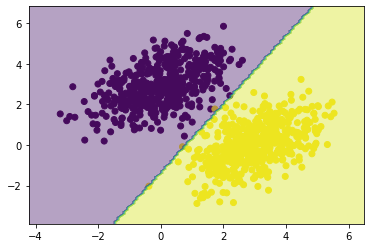

In [11]:
def plot_1(test_data, test_labels, predict_func, weights):
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)

    # Plotting decision regions
    x_min, x_max = test_data[:, 0].min() - 1, test_data[:, 0].max() + 1
    y_min, y_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = predict_func(np.c_[xx.astype(np.float32).ravel(), yy.astype(np.float32).ravel()], weights)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.show()


plot_1(test_data_1, test_labels_1, p_1.predict, w_1)

**Task 2**

Using the perceptron functions defined above, implement predict/train functions for multi-class classifier.

The predict function should take a matrix of features, a matrix with weights of the perceptron classifiers and return a vector of labels. Use either one-against-all or one-against-one method when implemeting this function. Justify your method selection in the report.

The train function should take a matrix of features, a vector of labels and return the trained classification model (a matrix with perceptron weights). Here you need to utilize the perceptron train functions developed in Task 1.

Characterize the accuracy of the classifier using the [confusion matrix](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).



## Solution to Task 2

### Wrapping the Perceptron from Task 1

In [12]:
@dataclass
class MultiPerceptron(Perceptron):
    
    def train(self, feat_matrix: np.array, label_vector: np.array) -> List[Any]:
        # create an empty weight holder
        weights = []
        # split and group the matrices
        for labels in self._split_data(feat_matrix, label_vector):
            w = np.random.rand(1 + feat_matrix.shape[1])
            w[0] = 0
            weights.append(super().train(feat_matrix, labels, w))
        return weights

    def _split_data(self, feat_matrix: np.array, label_vector: np.array) -> Iterator[np.array ]:
        # get the unique labels. 
        self._labels = tuple(np.unique(label_vector))

        # split the dataset into the correct number of training sets
        for l in self._labels:
            yield np.where(label_vector == l, 1, -1)
    
    def multipredict(self, feat_matrix: np.array, weights: list) -> np.array:
        # overload the predict function from above
        labels = np.vstack([[l] * feat_matrix.shape[0] for l in self._labels]).T
        prediction = np.zeros_like(labels)
        for i, w in enumerate(weights):
            prediction[:, i] = self.model(feat_matrix, w)
        return labels[0, np.argmax(prediction, 1)]


### Splitting Data into Test and Train 

In [13]:
data = features
labels = np.array([*([1] * num_samples_per_class), *([2] * num_samples_per_class), *([3] * num_samples_per_class)]).astype(np.float32)

In [14]:
# Split the Data into Training and Test
choice = np.random.choice(range(data.shape[0]), size=(int(data.shape[0] / 2),), replace=False)    
ind = np.zeros(data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

train_data_2 = data[ind]
train_labels_2 = labels[ind]

test_data_2 = data[rest]
test_labels_2 = labels[rest]

###  Training the Classifier

In [15]:
p_2 = MultiPerceptron()

# training the perceptron
w_2 = p_2.train(feat_matrix=train_data_2, label_vector=train_labels_2)

In [16]:
prediction_2 = p_2.multipredict(test_data_2, w_2)

### Calculating The Confusion Matrix Score

In [17]:
def confusion_matrix_display(p, prediction, labels):
    for l in p._labels:
        p.high = l
        p.low = -1
        prediction_local = np.where(prediction == l, l, -1)
        labels_local = np.where(labels == l, l, -1)
        print(f"The Confusion Matrix Score of the perceptron for category {l} is {round(confusion_matrix(prediction_local, labels_local, p) * 100, 3)}% ")

In [18]:
confusion_matrix_display(p_2, prediction_2, test_labels_2)

The Confusion Matrix Score of the perceptron for category 1.0 is 99.733% 
The Confusion Matrix Score of the perceptron for category 2.0 is 99.933% 
The Confusion Matrix Score of the perceptron for category 3.0 is 99.8% 


### Plotting the Results

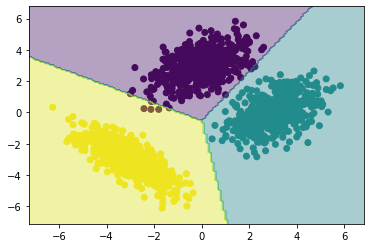

In [19]:
plot_1(test_data_2, test_labels_2, p_2.multipredict, w_2)

**Task 3**

Implement the same multi-class classfier using [Tensorflow's GradientTape](https://www.tensorflow.org/guide/autodiff) in the training functions (also see examples in Chapter 3 of the textbook).

Notes:
- a hard limiter function is not the best choice here. Use sigmoid or other activation function.
- Keep the functions implemented in the Task 2 the same and redefine the train/predict functions implemened in Task 1
- You could implement a different approach and train all neurons at once



## Solution to Task 3

### Imports

In [20]:
import tensorflow as tf

### Overloading the Perceptron and MultiPerceptron Classes

In [21]:
@dataclass
class TFPerceptron(Perceptron):
    
    def train(self, feat_matrix: np.array, label_vector: np.array, weights: Union[np.array, None] = None) -> np.array:
        W = tf.Variable(initial_value=tf.random.uniform(shape=(feat_matrix.shape[1], 1))) 
        b = tf.Variable(initial_value=tf.zeros(shape=(feat_matrix.shape[1],)))
        for _ in range(self.train_iterations):
            _, W, b = self.training_step(feat_matrix, label_vector, W, b)
        return (W, b)

    def square_loss(self, targets, predictions):
        per_sample_losses = tf.square(targets - predictions) 
        return tf.reduce_mean(per_sample_losses)

    def _model(self, inputs: np.array, W, *args, **kwargs) -> np.array:
        return tf.add(tf.matmul(inputs, W[0]), W[1])

    def model(self, *args, **kwargs):
        p = tf.nn.relu(self._model(*args, **kwargs))
        return p if len(p.shape) < 2 else p[:, 0]

    def training_step(self, inputs, targets, W, b):
        with tf.GradientTape() as tape: 
            predictions = self.model(inputs, (W, b))
            loss = self.square_loss(predictions, targets)
        grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
        W.assign_sub(grad_loss_wrt_W * self.alpha) 
        b.assign_sub(grad_loss_wrt_b * self.alpha) 
        return loss, W, b
        

In [22]:
class TFMultiPerceptron(MultiPerceptron, TFPerceptron):
    """
    This class exists only to overload the Perceptron Parent Class with the TF Percetron Class
    """
    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)

### Training the Classifier

In [23]:
# using the test and train data from above
p_3 = TFMultiPerceptron(train_iterations=1000, alpha=0.1)

# training the perceptron
w_3 = p_3.train(feat_matrix=train_data_2, label_vector=train_labels_2)


2022-02-07 09:40:30.180695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/targets/x86_64-linux/lib:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/share/lib
2022-02-07 09:40:30.180771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/targets/x86_64-linux/lib:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/share/lib
2022-02-07 09:40:30.180848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/targets/x86_64-linux/lib:/usr/lib/cuda/

In [24]:
prediction_3 = p_3.multipredict(test_data_2, w_3)

### Calculating The Confusion Matrix Score

In [25]:
confusion_matrix_display(p_3, prediction_3, test_labels_2)

The Confusion Matrix Score of the perceptron for category 1.0 is 100.0% 
The Confusion Matrix Score of the perceptron for category 2.0 is 100.0% 
The Confusion Matrix Score of the perceptron for category 3.0 is 100.0% 


### Plotting the Results

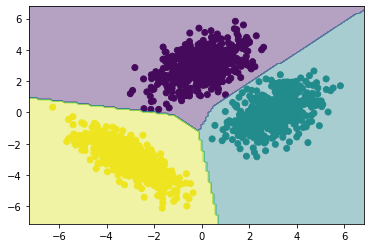

In [26]:
# plot_1(test_data_2, test_labels_2, p_3.multipredict, w_3)


plt.scatter(test_data_2[:, 0], test_data_2[:, 1], c=test_labels_2)

# Plotting decision regions
x_min, x_max = test_data_2[:, 0].min() - 1, test_data_2[:, 0].max() + 1
y_min, y_max = test_data_2[:, 1].min() - 1, test_data_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = p_3.multipredict(np.c_[xx.astype(np.float32).ravel(), yy.astype(np.float32).ravel()], w_3)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)

plt.show()



**Grading**

- (10 pts) Report quality / submission requirement followed (see class policy)
- (30 pts) Task 1
- (30 pts) Task 2
- (30 pts) Task 3

**Report** (your report goes here, keep the length manageable)
Report may also be submitted as a pdf document in the same compressed folder.

- Introduction
- Methods
- Results
- Discussion/Conclusions

Introduction. The introduction should clearly indicate the problem and the methods used to solve the problem.

Methods. Describe the algorithm and all critical parts of the implementation; including short descriptions of the function calls and functionality provided by those function calls.

Results. Provide a clear description of the test cases and illustrate the results by graphs, screenshots, etc.

Discussion. Explain the meaning of the results. Did the method work and good enough for practical use? If several methods were used, how do they compare? Is there any further possibility of improvement?

Software listing and executable software. Provide clear instructions how to run the software and execute the test cases shown in the report. The test cases should be able to run with no more than one click of a button. (Hint: use shell scripts to automate test cases) 

\pagebreak

## Report

**Max Schrader**

**1/27/22**

### Introduction

Homework #1 called for the creation of a multi-class classifier algorithm using both a **numpy** implentation of Rosenblatt's perceptrons as well as an equivalent **Tensorflow** implementation. Specifically, we were aaked to seperate 3 randomly generated distributions of $x, y$ points into 3 categories ($[1, 2, 3]$). The three distributions had differing means and covariances. The *features* of the data were the $x, y$ coordinates, making the input dimension $2$.

Task 1 called for the seperation of just 2 distributions, meaning that it was a binary classification problem. Tasks 2 & 3 used all three distributions and therefore had to have an additional layer to turn the binary linear classifier from Task 1 into multi-class identifiers.

### Methods

#### Part 1

In part one, the `Perceptron` class implements both training and prediction of a binary linear classifier. 

The `Perceptron.train` method takes the feature matrix and label vectors as an argument are returns the trained weights. The weights are initialized as an array filled with random values between $[0, 1)$. The weights, $w$ have the dimension of $(N + 1)\times L$, where $N$ is the dimension of the input data and $L$ is the dimension of the labels. It is $N + 1$ in order to account for bias in the dataset. In the linear classifier this manifests in the linear equation:

$$\left[w_1,w_2\right]\cdot[x,y]+[w_0]$$

which is represented in the `Perceptron.model` method. The `Perceptron._hard_limiter` funtion implements the hardlimiter function, where any output of the `Perceptron.model` $\geq 0$ is categorized in one category and those $< 0$ are labelled as the other.

Before training the `Perceptron` class, the data generated as part of the homework problem description is split into two sets of data using a set of random indicies.

Once the data is seperated, the `Perceptron` class is trained and then the trained weights are applied to the test data. To analyse the efficacy of the classification algorithm, the [F1 Algorithm](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234) is applied. Finally the data is plotted to show the classification boundary of the trained.


It's important to note that the the number of training iterations used was partially arbitrary, as well as the learning rate. I did not do a comparison of classification error vs. training iterations, but could and likely should have. In this case the training wall clock time was irrelevant.

#### Part 2

Part 2 asked us to develop a mulit-class classifier using Rosenblatt's perceptron. The `MultiPerceptron` extends the `Perceptron` class from **Part 1** to enable multiclass-classification. It can handle an arbitrary number of classes, as it dynamically slices label vector according to the number of unique lables. 

There were two options for doing the multi-class classification: one-against-all and one-against-one. I chose to use **one-against-all** as it requires $N$ binary classifier models in comparison to **one-against-one** which needs $\frac{N(N - 1)}{2}$. When there are 3 classes the number of classifiers for both **one-against-all** and **one-against-one** are equal, but **one-against-all** scales linearly with the number of classes whereas **one-against-all** does not.

Using the **one-against-all** method, three binary classifiers were trained, each "learning" to classify one class against all others. This meant that the label vector the to perceptron from task one needed to manipulated to make it binary label vector. For each of the three classifiers, the input vector was manipulated to contain a $1$ where the label == the considered class and a $-1$ otherwise.

To find the class in which each point belonged, the three classifiers were passed over the data and then the $argmax_{x_i}{f_i}$ was found, corresponding to the prediction label.

Finally, the confusion matrix score for each of the classes was calculated and the results were plotted. 

#### Part 3

Departing from the binary perceptrons of Part 1 & 2, Task 3 asked us to implement a multi-class classifier using [Tensorflow's GradientTape](https://www.tensorflow.org/guide/autodiff). Instead of the hard-limiter function, we could instead use any activation function.

The solution was implemented using the `TFPerceptron` and `TFMultiPerceptron` classes. In the `TFPerceptron` class, a `model` function is created with creates the linear classifier in the Tensorflow convention. The `predict` function wraps the `model` function in the Tensorflow `relu` activation function which was found to perform the best. The `training_step` function computes the gradient of the loss function and propigates it through the layer.

`TFMultiPerceptron` overloads the `MultiPerceptron` class from **Task 2** with the new tensorflow-enable perceptron class (`TFPerceptron`). The multi-class prediction method from **Task 2** is held the same here.

The `TFMultiPerceptron` is then trained on the data (which was split into test and training) in step two. Finally the accuracy for each class is found and the decision boundaries are plotted.

### Results 

#### Task 1

The results for **Task 1** are displayed below. Two sets of multivariate distributions were seperated with nearly a 100% accuracy  

##### Accuracy

In [27]:
accuracy_1(prediction_1, test_labels_1, p_1)

The F1 Score of the perceptron is 99.9% 


##### Classification Plot

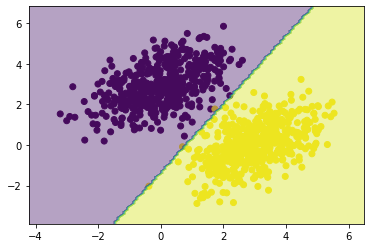

In [28]:
plot_1(test_data_1, test_labels_1, p_1.predict, w_1)

#### Task 2

In **Task 2**, 3 sets of multivariate distrubutions were classified with near 100% accuracy.

##### Accuracy

In [29]:
confusion_matrix_display(p_2, prediction_2, test_labels_2)

The Confusion Matrix Score of the perceptron for category 1.0 is 99.733% 
The Confusion Matrix Score of the perceptron for category 2.0 is 99.933% 
The Confusion Matrix Score of the perceptron for category 3.0 is 99.8% 


##### Classification Plot

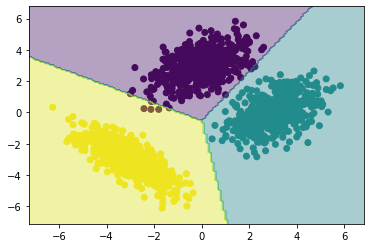

In [30]:
plot_1(test_data_2, test_labels_2, p_2.multipredict, w_2)

#### Task 3

In **Task 3**, 3 sets of multivariate distributions (the same as **Task 2**) were classified with near (or sometimes complete) 100% accuracy. The benefit of using the relu activation function is clear in the non-linear seperation boundary. 

In [31]:
confusion_matrix_display(p_3, prediction_3, test_labels_2)

The Confusion Matrix Score of the perceptron for category 1.0 is 100.0% 
The Confusion Matrix Score of the perceptron for category 2.0 is 100.0% 
The Confusion Matrix Score of the perceptron for category 3.0 is 100.0% 


##### Classification Plot

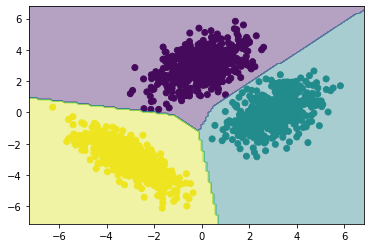

In [32]:
plot_1(test_data_2, test_labels_2, p_3.multipredict, w_3)

### Discussion

All three methods performed well. The multiclass classifier built in **Task 2** was nearly as perfomat as the Tensorflow implementation in **Task 3**, with significantly less overhead.

It is hard for me to say whether this could be used in practical settings. I would want to know more about the consequences of false-negatives in the environment that these algorithms would be implemented in. 

If accuracy was the ultimate target, I would use the Tensorflow implementation from part 3, but I would want to also explore non-linear classification methods.